# Advanced usage of HiPS and MOCs
## Exploring large catalogs within non-trivial spatial coverage, defined by brightness cuts and/or the availability of additional data sets
Originally by 

**Caroline Bot and Thomas Boch, CDS**

as published on http://www.euro-vo.org/?q=science/scientific-tutorials
converted to jupyter notebook by 

**Katharina Lutz, Thomas Boch, Matthieu Baumann, CDS**

This tutorial was first presented at "Detecting the unexpected, Discovery in the Era of Astronomically Big Data" Space Telsecope Science Instite, February 27 - March 2, 2017. It was updated to Aladin v10 in June 2017 and to Gaia DR2 in June 2018. 

Updated by **Stefania Amodeo** in November 2021


This is a hands-on tutorial demonstrating an advanced useage of Hierarchical Progressive Suerveys (HiPS) and Multi-Order Coverage (MOC) maps in Aladin. Using this tutorial you will learn to handle a problem like: 
>"I have a set of images, I would like to select regions in my observations that are above a given threshold in another survey (e.g. at low extinction), retrieve objects from very large catalogues (e.g. Gaia + WISE) in these non-trivial shapes and not-necessarily-connected regions and combine them to visualise some quantities (e.g. colour-colour diagram). "

## Step 1: Before we get started
The original tutorial was using Aladin (https://aladin.u-strasbg.fr/) and TOPCAT (http://www.star.bris.ac.uk/~mbt/topcat/), in this version of the tutorial we will use python packages to accomplish the same tasks. The python packages include MOCpy (https://github.com/cds-astro/mocpy), astroquery (https://astroquery.readthedocs.io/en/latest/), pyVO (https://pyvo.readthedocs.io/en/latest/), healpy (https://healpy.readthedocs.io/en/latest/) as well as astropy and matplotlib. 

Now let's go!

In [1]:
import warnings 
import glob
import os

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.coordinates import SkyCoord, Angle, match_coordinates_sky
import astropy.units as u
import mocpy
import pyvo
import healpy as hp
from astroquery.vizier import Vizier

warnings.filterwarnings('ignore')

## Step 2: Find all Short-Red images associated to the MASH catalog using the VizieR associated data service
The VizieR service at CDS allows you to look for astronomical catalogues that have been published in the literature. Among these catalogues, some contain data associated to the publications and the tables therein. These data can be browsed and explored through the VizieR associated data service, which is linked to the traditional VizieR table service. In the current example we are looking for images associated with the MASH catalogue of planetary nebulae (Parker et al 2006-2008). The MASH fits files are cut-outs extracted from a larger H$\alpha$ and Short Red survey and can be best described as a set of regions of interest around planetary nebulae. 

To find VizieR associated data, we use the Table Access Protocol (TAP) with the VizieR endpoint. Through the VizieR TAP endpoint we can search for tables, content of tables and for information on associated data. 

First we search for the MASH catalogue:

In [2]:
tap_vizier = pyvo.dal.TAPService('http://tapvizier.u-strasbg.fr/TAPVizieR/tap')

query = '''
SELECT  *  FROM tables 
WHERE description LIKE '%MASH%Parker%'
'''

mash_catalogues = tap_vizier.search(query).to_table()
mash_catalogues

schema_name,table_name,table_type,description,utype
object,object,object,object,object
V_combined,V/127A/mash1,table,"The MASH Catalog of Planetary Nebulae (paper I) ( Parker Q.A., Acker A., Frew D.J., Hartley M., Peyaud A.E.J., Phillipps S., Russeil D., Beaulieu S.F., Cohen M., Koppen J., Marcout J., Miszalski B., Morgan D.H., Morris R.A.H., Ochsenbein F., Pierce M.J.,)",
J_MNRAS,J/MNRAS/412/223/mpgs2,table,"MASH PNe detected in the MPGS-2 (Cat. VIII/82) ( Bojicic I.S., Parker Q.A., Filipovic M.D., Frew D.J.)",
J_MNRAS,J/MNRAS/412/223/table4,table,"The nine MASH PNe detected and possibly detected in the PMN survey ( Bojicic I.S., Parker Q.A., Filipovic M.D., Frew D.J.)",
V_combined,V/127A/mash2,table,"The MASH-II Supplement (from paper II) ( Parker Q.A., Acker A., Frew D.J., Hartley M., Peyaud A.E.J., Phillipps S., Russeil D., Beaulieu S.F., Cohen M., Koppen J., Marcout J., Miszalski B., Morgan D.H., Morris R.A.H., Ochsenbein F., Pierce M.J.,)",
J_MNRAS,J/MNRAS/412/223/table1,table,"MASH PNe detected in the NVSS ( Bojicic I.S., Parker Q.A., Filipovic M.D., Frew D.J.)",


For this tutorial, we are interested in the tables belonging to the catalogues `V/127A`, this includes tables `V/127A/mash1` and `V/127A/mash2`. To have a look at the content of these tables we do the following:

In [3]:
query = '''
SELECT TOP 5 * FROM \"V/127A/mash1\" 
'''
mash1_head = tap_vizier.search(query).to_table()
mash1_head

recno,n_PNG,PNG,Name,RAJ2000,DEJ2000,GLon,GLat,MajDiam,MinDiam,CS,Morph,Tel,ObsDate,HaExp,HaFld,Comments,img,ImageHa,ImageSr,AssocData
,,,,deg,deg,deg,deg,arcsec,arcsec,,,,&quot;Y:M:D&quot;,,,,,,,
int32,str1,object,object,float64,float64,float64,float64,float64,float64,object,object,object,float64,object,object,object,object,object,object,object
29,L,G234.7-02.2,PHR0724-2021,111.05458333333331,-20.36361111111111,234.7045,-2.2774,134.5,54.0,,A,SA,2452672.0,HA18201,HA842,"Large, very faint diffuse arcuate nebula; has [NII]~2xH-alpha, nothing in blue",1029,img_ha,img_sr,fits
2,P,G227.3-12.0,PHR0633-1808,98.35374999999999,-18.13972222222222,227.3207,-12.0289,17.0,15.0,,Ea,SA,2452672.0,HA18191,HA926,"Very faint, partial arcuate nebula also observed M1 060100; [NII]~0.8xH-alpha, strong [SII], only weak H-beta in blue - inconclusive",1002,img_ha,img_sr,fits
16,T,G227.2-03.4,PHR0705-1419,106.41041666666665,-14.318055555555553,227.2852,-3.4029,15.0,15.0,,E,SA,2452668.0,HA18244,HA1017,"Small, circular PN around a faint central star; also observed M1 040100; [NII]~0.7 H-alpha, [OIII]>>H-beta",1016,img_ha,img_sr,fits
5,L,G223.6-06.8,PHR0646-1235,101.60583333333332,-12.598888888888887,223.6338,-6.8035,40.0,37.0,,E,SA,2453788.0,HA18194,HA1016,Slightly oval very faint PN candidate - has [OIII] and H-alpha,1005,img_ha,img_sr,fits
10,P,G224.3-05.5,PHR0652-1240,103.08458333333331,-12.67611111111111,224.3504,-5.5463,187.0,180.0,,I,SA,2452670.0,HA18244,HA1017,"Faint, extended S-shaped emission nebula, possible evolved PN, also observed M1 080100; has [NII]~0.8Ha, [OIII], strong [SII], [OIII]>H-beta",1010,img_ha,img_sr,fits


As you can see, the last column of this table is called `AssocData` and contains the entry `fits`. If you look at this table on the VizieR web interface, you can download the associated fits file. Within this notebook, we query the `obscore` database to get the URLs to the fits file. Using the `astropy.io.fits` module, we can then open the fits files from their URLs.

In [4]:
obs_tap_vizier = pyvo.dal.TAPService('http://cdsarc.u-strasbg.fr/saadavizier.tap/tap')
query = """
SELECT TOP 5  *  FROM obscore 
WHERE obs_collection='V/127A'
"""
mash_fits = obs_tap_vizier.search(query).to_table()
# mash_fits = tap_vizier.search(query).to_table()
mash_fits

access_estsize,access_format,access_url,bib_reference,calib_level,dataproduct_type,em_band,em_max,em_min,extension,facility_name,has_wcs,instrument_name,obs_collection,obs_id,obs_publisher_did,oidsaada,o_ucd,pol_states,s_dec,s_fov,s_ra,s_region,s_resolution,target_name,t_exptime,t_max,t_min,t_resolution
kbyte,,,,,,spect,,,meta.code,,meta.code,,,,,,,,deg,deg,deg,,arcsec,,,,,
int64,object,object,object,int32,object,object,float64,float64,int32,object,int32,object,object,object,object,object,object,object,float64,float64,float64,object,float64,object,float64,float64,float64,float64
820800,application/fits,https://cdsarc.cds.unistra.fr/saadavizier/download?oid=864975549779412807,2006MNRAS.373...79P,-1,image,Optical,1e-06,3e-07,--,UKST,5,SuperCOSMOS I,V/127A,2035_ha.fits,ivo://CDS.VizieR/V/127A?res=2035_ha.fits,864975549779412807,obs.image,NotSet,-61.24103895238569,0.1353099071501567,150.76362829842026,Polygon ICRS 150.83066088850273 -61.27512696994166 150.69268656560695 -61.27325601074809 150.69674095404145 -61.20691792889612 150.8344247306261 -61.208784921732,0.9485391797618027,,--,--,51282.0,--
682560,application/fits,https://cdsarc.cds.unistra.fr/saadavizier/download?oid=864975549779411194,2006MNRAS.373...79P,-1,image,Optical,1e-06,3e-07,--,UKST,5,SuperCOSMOS I,V/127A,1128_sr.fits,ivo://CDS.VizieR/V/127A?res=1128_sr.fits,864975549779411194,obs.image,NotSet,-62.004049270831246,0.1555609497018379,163.65152213971035,Polygon ICRS 163.72572187488603 -62.035507542847576 163.5844491573649 -62.038817959994745 163.5774756087238 -61.97255125347644 163.7184421013424 -61.9692481116068,0.9474858544424722,,--,--,50833.0,--
820800,application/fits,https://cdsarc.cds.unistra.fr/saadavizier/download?oid=864975549779411221,2006MNRAS.373...79P,-1,image,Optical,1e-06,3e-07,--,UKST,5,SuperCOSMOS I,V/127A,1143_ha.fits,ivo://CDS.VizieR/V/127A?res=1143_ha.fits,864975549779411221,obs.image,NotSet,-60.03454342981924,0.14848490759765912,169.79477364314278,Polygon ICRS 169.86269397646956 -60.06696590715432 169.7297788674058 -60.06842810546378 169.7269865780568 -60.002086181283936 169.8596351546945 -60.000626916580345,0.9486023377493588,,--,--,51673.0,--
760320,application/fits,https://cdsarc.cds.unistra.fr/saadavizier/download?oid=864975549779411901,2006MNRAS.373...79P,-1,image,Optical,1e-06,3e-07,--,UKST,5,SuperCOSMOS I,V/127A,1490_ha.fits,ivo://CDS.VizieR/V/127A?res=1490_ha.fits,864975549779411901,obs.image,NotSet,-34.433179225730036,0.06855891462831788,263.5568937277435,Polygon ICRS 263.5961159354412 -34.46716892251153 263.51569575956137 -34.46547978146073 263.5177034164792 -34.39917701736539 263.59805985638724 -34.400864865363566,0.9482059362570522,,--,--,52080.0,--
624960,application/fits,https://cdsarc.cds.unistra.fr/saadavizier/download?oid=864975549779411326,2006MNRAS.373...79P,-1,image,Optical,1e-06,3e-07,--,UKST,5,SuperCOSMOS I,V/127A,1197_sr.fits,ivo://CDS.VizieR/V/127A?res=1197_sr.fits,864975549779411326,obs.image,NotSet,-62.85107425955727,0.16253158563524112,193.8247478513678,Polygon ICRS 193.90225285513202 -62.88190707717904 193.7570303959433 -62.8864079380107 193.74740545595878 -62.820198962085115 193.892302556318 -62.81570816256475,0.9466957826104866,,--,--,50864.0,--


As you can see, the result from this query proivides us with information of the fits files, which are associated with the MASH catalogues. In particular the column `access_url` provides us with the location of the data. To get the first image we could do:

`image = fits.open(mash_fits['access_url'][0])`

and then work on the image, plot it or save it to our machine. However downloading all the data and working with all the data, takes quite some time. So, for the purpose of this tutorial, **we prepared a subsample of 335 of these Short Red images that will run in a timely manner** but we encourage you to repeat with the full Short Red sample later. **The subsample is available at 
http://astro.u-strasbg.fr/~bot/BochBot.tar.gz** and in the Data Folder of this repository. So if you run this tutorial on Binder, you do not need to download anything. 

## Step 3: Create a MOC of the MASH images
The multi-order coverage (MOC) map of a set of images is a useful representation of the sky coverage of these images. MOCs can represent arbitrary patches on the sky, which do not need to be connected. The union or intersection of two MOCs can be calculated quickly and with small computational effort. Catalogues can be filtered by MOCs. 

Here we want to use the fits files we just downloaded to create a MOC map of the MASH images.

#### Organise your data

In [26]:
datadir = 'Data/MASH_Sample/' #where to find fits images downloaded from the archive above
outdir = 'Result_moc/'        #Make new directory where to save MOCs

if not os.path.exists(outdir):
    os.mkdir(outdir)

In most cases the following cell can be ignored.  However, some possible deprecated keywords in the fits header would hamper the MOC creation because they would cause errors in the underlying `astropy.wcs.WCS` module. Therefore, we rewrite the headers of the fits files so that they only contain the useful keywords needed to define the coordinate frame correctly before using `mocpy`. 

In [6]:
# Get a list of all fits files 
mash_file_list = glob.glob(datadir+'*.fits')

# Modify the header so that the MOC creation works smoothly

for file_name in mash_file_list:
    ima = fits.open(file_name) 
    hdr = ima[0].header
    needed_keywords = ['SIMPLE','BITPIX', 'NAXIS','EXTEND',                     # basic fits keywords 
                       'NAXIS1', 'NAXIS2', 'RADECSYS',                          # essential WCS keywords
                       'CD1_1','CD1_2','CD2_1','CD2_2',                         
                       'CTYPE1', 'CUNIT1', 'CDELT1', 'CRPIX1', 'CRVAL1', 
                       'CTYPE2', 'CUNIT2', 'CDELT2', 'CRPIX2', 'CRVAL2',
                       'EQUINOX', 'BLANK'                                       # used additionally by mocpy
                        ]
    new_hdr = fits.Header()
    for keyword in needed_keywords:
        try:
            new_hdr[keyword] = ima[0].header[keyword]
        except KeyError:
            continue
    new_hdr['RADESYS'] = new_hdr['RADECSYS']
    fits.writeto(outdir+file_name[len(datadir):].split('.fits')[0] + '_mod.fits', 
                 ima[0].data, new_hdr, output_verify='fix', overwrite=True)
    ima.close()

### Create the MOC

Here we can create the MOC of the MASH images with the `MOCPy` module. 

WARNING! 

If you are running the notebook on Binder, check that the cell above has actually created the files `*_mod.fits` in the directory `Result_moc`. 
We have noticed that this does not always work, probably because of connection problems. If this is the case, please use the backup file  `Data/mash_moc.fits` (do not run the cell below and use the next one instead).

You should not have this issue if you run the notebook on your machine.

In [7]:
# Get a list of the updated files and create the MOC    

mash_file_list = glob.glob(outdir+'*_mod.fits')
moc_mash = mocpy.MOC.from_fits_images(mash_file_list, max_norder=15)
moc_mash.write(outdir+'mash_moc.fits', overwrite=True)

In [8]:
#moc_mash = mocpy.MOC.from_fits('Data/mash_moc.fits')

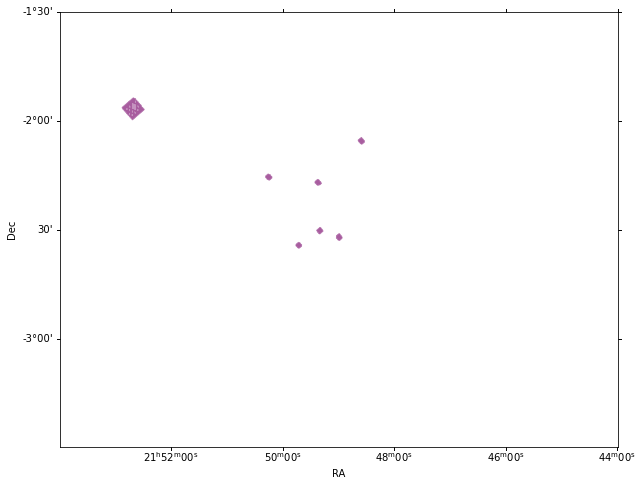

In [9]:
fig_centre = SkyCoord('21:49:00', '-02:30:00', 
                      unit=(u.hourangle, u.deg), frame='galactic')

#sns.set_style('darkgrid')
fig = plt.figure(figsize=(10, 8))
with mocpy.World2ScreenMPL(fig, fov=2.5 * u.deg,
                           center=fig_centre,
                           coordsys="galactic", 
                           rotation=Angle(0, u.degree),
                           projection="AIT") as wcs:
    ax = fig.add_subplot(1, 1, 1, projection=wcs)
    #ax = fig.add_axes([0.17, 0.17, 0.77, 0.77], projection=wcs)
    moc_mash.fill(ax=ax, wcs=wcs, alpha=0.5, fill=True, color=mpl.cm.magma(0.4))
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    lon, lat = ax.coords[0], ax.coords[1]
    lon.set_major_formatter('hh:mm:ss')
    lat.set_major_formatter('dd:mm')
    lon.set_ticklabel(exclude_overlapping=True)
    lat.set_ticklabel(exclude_overlapping=True)

This figure only shows a small region on the Sky, but you can see how the MOC has arbitrary shapes and not all regions are connected. 

## Step 4: Load an archival extinction map and create the MOC of the low extinction regions
Different works (e.g. Schlegel et al. 1998, Schlafly  & Finkbeiner 2011, Green et al. 2015 or Dobashi et al. 2013) have created extinction maps of the sky and these maps are publicly available. Some of these maps are all-sky maps, other have higher resolutions, or come from different methods... Such maps are available in healpix format (among others) on the LAMBDA website or the CADE website. For the purpose of this tutorial, we will download the well known all-sky extinction map from Schlegel et al. from the LAMBDA website, and define as a MOC the low extinction area for which 0<E(B-V)<0.5. 
The map is available from here: https://lambda.gsfc.nasa.gov/data/foregrounds/SFD/lambda_sfd_ebv.fits and we save it to disc. 

In [10]:
ext_map = fits.open('https://lambda.gsfc.nasa.gov/data/foregrounds/SFD/' + 
                    'lambda_sfd_ebv.fits')
ext_map.writeto('Data/Schlegel_extinction_map.fits', overwrite=True)
ext_map.close()

We are only interested in regions with low extinction. So our aim is to get a MOC of all regions, where the extinction values from the Schlegel et al. map are in the range from 0 to 0.5mag. The extinction map we got from the NASA webpage is in the Healpix format, which is a very useful and efficient presentation of all-sky maps. The Healpix tesselation is also used by the MOCs. So to get the MOC from the extinction map, we do the following. First we change the projection of the map and set the order (i.e. resolution) of the map, so that the resulting MOC will have the right shape:

In [27]:
hdul = fits.open('Data/Schlegel_extinction_map.fits')  # open a FITS file
hdr = hdul[0].header
hdr

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   32 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
DATE    = '2003-02-05T00:00:00' /file creation date (YYYY-MM-DDThh:mm:ss UT)    
OBJECT  = 'ALL-SKY '           / Portion of sky given                           
COMMENT   This file contains an all-sky Galactic reddening map, E(B-V), based on
COMMENT   the derived reddening maps of Schlegel, Finkbeiner and Davis (1998).  
COMMENT   Software and data files downloaded from their website were used to    
COMMENT   interpolate their high resolution dust maps onto pixel centers        
COMMENT   appropriate for a 

In [11]:
# Read the map
ext_map = hp.read_map('Data/Schlegel_extinction_map.fits', nest=False)
# This in Galactic coordinate system, we define the coordinate transformation
r = hp.Rotator(coord=['G','C']) #Transforms galactic to equatorial coordinates
# do the coordinate and representation transformation
ext_map_equatorial_ring = r.rotate_map_pixel(ext_map)
ext_map_equatorial = hp.reorder(ext_map_equatorial_ring, r2n=True) #reorder from RING to NESTED
# set the resolution
nside = 512 #nside must be a power of 2, less than 2**30
norder = hp.nside2order(nside) #int, corresponding order where nside = 2**(order)

/Users/samodeo/opt/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/Users/samodeo/opt/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 512
  warnings.warn("NSIDE = {0:d}".format(nside))
/Users/samodeo/opt/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/Users/samodeo/opt/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:426: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))
/Users/samodeo/opt/anaconda3/lib/python3.8/site-pack

Next we declare which pixel we want to use, i.e. all pixels with low extinction:

In [12]:
indexes_pixels_to_keep = np.where((ext_map_equatorial<0.5) & 
                                  (ext_map_equatorial>0.0))[0]

#without the "[0]", np.where returns a tuple where the first element is the array of indices
# we need the array to be passed to the MOC creator
#without "[0]" we wouldn't get an error at the next step because a tuple doesn't have a shape

Since we brought the extinction map in the right shape, the indexes of the pixels that we want to keep are the indexes of the Healpix cells we are interested in. Thus the MOC is created by:

In [13]:
moc_low_ext = mocpy.MOC.from_healpix_cells(indexes_pixels_to_keep, 
                                           np.full((len(indexes_pixels_to_keep,)), 
                                                    norder))

In [14]:
moc_low_ext.write('Data/low_extinction_moc.fits', overwrite=True)

## Step 5:  Find out which regions are covered by the MASH short red images and in the low extinction regions defined above

To find out which regions of the sky are covered by the MASH sample and which are at low extinction, we build the intersection of the two MOCs.

In [15]:
moc_intersection = moc_low_ext.intersection(moc_mash)
moc_intersection.sky_fraction

1.2931336641486268e-05

Now we can visualise the coverage of the two MOCs and their intersection. The grey area is where the extinction is low, the blue area is the MASH coverage and the red area is the MASH coverage in low extinction regions. 

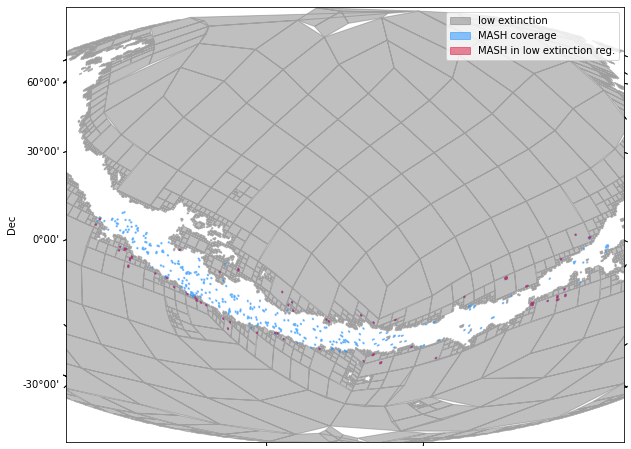

In [16]:
fig = plt.figure(111, figsize=(10, 8))
with mocpy.World2ScreenMPL(fig, fov=200 * u.deg,
                           center=SkyCoord(200, -20, unit='deg', frame='icrs'),
                           coordsys="icrs",
                           rotation=Angle(0, u.degree),
                           projection="AIT") as wcs:
    ax = fig.add_subplot(1, 1, 1, projection=wcs)
    moc_low_ext.fill(ax=ax, wcs=wcs, alpha=0.5, fill=True, color="grey",label='low extinction')
    moc_mash.fill(ax=ax, wcs=wcs, alpha=0.5, fill=True, color="dodgerblue", label='MASH coverage')
    moc_intersection.fill(ax=ax, wcs=wcs, alpha=0.5, fill=True, color="crimson", label='MASH in low extinction reg.')
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    lon, lat = ax.coords[0], ax.coords[1]
    lon.set_major_formatter('hh:mm:ss')
    lat.set_major_formatter('dd:mm')
    lon.set_ticklabel(exclude_overlapping=True)
    lat.set_ticklabel(exclude_overlapping=True)
    lon.set_ticks(spacing=2 * u.hourangle)
plt.legend()
plt.show()

## Step 6: Query the 2MASS and Gaia Catalogue by MOC
Without the usage of MOC, querying for sources in the low extinction regions covered by the MASH subsample would be tedious or even impossible. Indeed, one would need to load the whole catalog and make selections which would not be possible given the size of some catalogues. Alternatively, one would need to query the catalogue field by field, which would take time and several queries. Instead, here, we will use the power of MOC files to query large catalogs directly in the covered regions only. We will use the coverage of the low extinction and MASH-covered region to query for sources from the Gaia and 2MASS surveys, in this highly non-continuous and non-trivial shape areas.

First let's see which Gaia and 2MASS catalogues are available on VizieR. We could as above use the TAP endpoint of VizieR or we use as shown below the `Vizier` module in the `astroquery` package. 

In [17]:
catalog_list_twomass = Vizier.find_catalogs('Cutri')
for k, v in catalog_list_twomass.items():
    print(k, ': ', v.description)

II/126 :  IRAS Serendipitous Survey Catalog (IPAC 1986)
II/241 :  2MASS Catalog Incremental Data Release (IPAC/UMass, 2000)
II/246 :  2MASS All-Sky Catalog of Point Sources (Cutri+ 2003)
II/281 :  2MASS 6X Point Source Working Database / Catalog (Cutri+ 2006)
II/307 :  WISE Preliminary Data Release (Cutri+ 2011)
II/311 :  WISE All-Sky Data Release (Cutri+ 2012)
II/328 :  AllWISE Data Release (Cutri+ 2013)
II/365 :  The CatWISE2020 catalog (updated version 28-Jan-2021) (Marocco+, 2020)
VII/233 :  The 2MASS Extended sources (IPAC/UMass, 2003-2006)
J/ApJ/560/566 :  K-band galaxy luminosity function from 2MASS (Kochanek+, 2001)
J/ApJ/564/421 :  Spectra of T dwarfs. I. (Burgasser+, 2002)
J/ApJ/569/23 :  Optical polarisation of 2MASS QSOs (Smith+, 2002)
J/ApJ/635/214 :  Chandra X-ray sources and NIR identifications (Ebisawa+, 2005)
J/ApJ/713/330 :  Spitzer observations of major-merger galaxies (Xu+, 2010)
J/ApJ/719/550 :  Deep NIR imaging of {rho} Oph cloud core (Marsh+, 2010)
J/ApJ/741/68 :

In [18]:
catalog_list_gaia = Vizier.find_catalogs('Gaia DR2')
for k, v in catalog_list_gaia.items():
    print(k, ': ', v.description)

I/345 :  Gaia DR2 (Gaia Collaboration, 2018)
I/347 :  Distances to 1.33 billion stars in Gaia DR2 (Bailer-Jones+, 2018)
I/349 :  StarHorse, Gaia DR2 photo-astrometric distances (Anders+, 2019)
II/360 :  Gaia DR2 x AllWISE catalogue (Marton+, 2019)
IV/35 :  Gaia DR2-WISE Galactic Plane Matches (Wilson+, 2018)
VI/156 :  M-dwarf Lum-Temp-Radius relationships (Morrell+, 2019)
VII/285 :  Gaia DR2 quasar and galaxy classification (Bailer-Jones+, 2019)
J/ApJ/862/138 :  BANYAN. XIII. Nearby young assoc. with Gaia DR2 (Gagne+, 2018)
J/ApJ/863/89 :  Gaia DR2 PMs of stars in ultra-faint MW satellites (Simon, 2018)
J/ApJ/866/99 :  Revised radii of KIC stars & planets using Gaia DR2 (Berger+, 2018)
J/ApJ/867/151 :  YSOs in the Gould Belt regions with Gaia-DR2 data (Dzib+, 2018)
J/ApJ/868/70 :  Hot subdwarf stars from Gaia DR2 and LAMOST DR5 (Lei+, 2018)
J/ApJ/870/32 :  Kinematics in young star clusters & associations (Kuhn+, 2019)
J/ApJ/872/85 :  Detached eclipsing binaries with Gaia parallaxes (Gr

For 2MASS we will want to use `II/246 :  2MASS All-Sky Catalog of Point Sources (Cutri+ 2003)` and for Gaia `I/345 :  Gaia DR2 (Gaia Collaboration, 2018)`. Before we actually query the two table we just get a few sources for each of the tables to understand, which columns are available etc. The query below will give us 50 sources each as is the default for the `get_catalogs` method.

In [19]:
test_twomass = Vizier.get_catalogs('II/246')
print(test_twomass)
test_twomass[0]

TableList with 1 tables:
	'0:II/246/out' with 15 column(s) and 50 row(s) 


RAJ2000,DEJ2000,_2MASS,Jmag,e_Jmag,Hmag,e_Hmag,Kmag,e_Kmag,Qflg,Rflg,Bflg,Cflg,Xflg,Aflg
deg,deg,,mag,mag,mag,mag,mag,mag,,,,,,
float64,float64,str17,float32,float32,float32,float32,float32,float32,str3,str3,str3,str3,uint8,uint8
44.880847,0.616721,02593140+0037001,13.799,0.025,13.222,0.026,13.167,0.037,AAA,222,111,000,0,0
44.919229,0.610531,02594061+0036379,16.794,0.158,16.093,0.170,15.451,0.206,CCC,222,111,000,0,0
44.921658,0.617475,02594119+0037029,14.666,0.033,14.261,0.043,14.140,0.067,AAA,222,111,000,0,0
44.906036,0.626795,02593744+0037364,15.339,0.050,14.535,0.051,13.654,0.045,AAA,222,111,000,0,0
44.935480,0.621464,02594451+0037172,16.350,0.198,15.759,0.266,15.198,0.208,CDC,222,111,ccc,0,0
44.937738,0.624476,02594505+0037281,8.227,0.023,8.079,--,7.871,--,AUU,166,100,c00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44.771958,0.697915,02590526+0041524,16.373,0.126,15.634,0.170,15.013,0.149,BCB,222,111,000,0,0


In [20]:
test_gaia = Vizier.get_catalogs('I/345')
print(test_gaia)
test_gaia[0]

TableList with 20 tables:
	'0:I/345/gaia2' with 32 column(s) and 50 row(s) 
	'1:I/345/rvstdcat' with 32 column(s) and 50 row(s) 
	'2:I/345/rvstdmes' with 7 column(s) and 50 row(s) 
	'3:I/345/allwise' with 2 column(s) and 50 row(s) 
	'4:I/345/iers' with 2 column(s) and 50 row(s) 
	'5:I/345/cepheid' with 25 column(s) and 50 row(s) 
	'6:I/345/rrlyrae' with 23 column(s) and 50 row(s) 
	'7:I/345/lpv' with 13 column(s) and 50 row(s) 
	'8:I/345/varres' with 9 column(s) and 50 row(s) 
	'9:I/345/shortts' with 9 column(s) and 50 row(s) 
	'10:I/345/tsstat' with 13 column(s) and 50 row(s) 
	'11:I/345/numtrans' with 4 column(s) and 50 row(s) 
	'12:I/345/transits' with 20 column(s) and 50 row(s) 
	'13:I/345/rm' with 9 column(s) and 50 row(s) 
	'14:I/345/rmseg' with 16 column(s) and 50 row(s) 
	'15:I/345/rmout' with 2 column(s) and 50 row(s) 
	'16:I/345/ssoobj' with 6 column(s) and 50 row(s) 
	'17:I/345/ssoorb' with 19 column(s) and 50 row(s) 
	'18:I/345/ssores' with 10 column(s) and 50 row(s) 
	'19:

RA_ICRS,e_RA_ICRS,DE_ICRS,e_DE_ICRS,Source,Plx,e_Plx,pmRA,e_pmRA,pmDE,e_pmDE,Dup,FG,e_FG,Gmag,e_Gmag,FBP,e_FBP,BPmag,e_BPmag,FRP,e_FRP,RPmag,e_RPmag,BP-RP,RV,e_RV,Teff,AG,E_BP-RP_,Rad,Lum
deg,mas,deg,mas,,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,e-/s,e-/s,mag,mag,e-/s,e-/s,mag,mag,e-/s,e-/s,mag,mag,mag,km / s,km / s,K,mag,mag,solRad,solLum
float64,float64,float64,float64,int64,float64,float32,float64,float32,float64,float32,uint8,float32,float32,float64,float64,float32,float32,float64,float64,float32,float32,float64,float64,float64,float64,float32,float64,float32,float32,float32,float64
294.20184527701,0.0874,18.52139162450,0.1155,1825095607396805760,0.2209,0.1562,-1.913,0.187,-4.406,0.231,0,866.8,1.05,18.3435,0.0013,286.4,6.159,19.2091,0.0234,967.3,11.45,17.2980,0.0129,1.9111,--,--,--,--,--,--,--
294.20389030109,0.9643,18.52332292185,1.6306,1825095607404100992,0.2810,2.6483,-3.848,2.090,-12.304,3.829,0,83.01,0.8343,20.8905,0.0109,30.59,4.139,21.6373,0.1469,120.8,8.44,19.5569,0.0759,2.0804,--,--,--,--,--,--,--
294.20883795959,0.8291,18.52136869280,1.0699,1825095607401646336,-0.4311,1.7161,-2.892,1.670,-1.943,2.406,0,91.52,0.7968,20.7846,0.0095,43.48,5.918,21.2557,0.1478,120.6,6.56,19.5590,0.0591,1.6967,--,--,--,--,--,--,--
294.20789208036,10.2723,18.52202274126,28.3331,1825095607404098816,--,--,--,--,--,--,0,61.26,1.937,21.2204,0.0343,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
294.20791486077,0.0591,18.52282958241,0.0807,1825095607429777152,0.6573,0.1050,-1.104,0.126,-3.844,0.166,0,1587,1.219,17.6871,0.0008,515,5.147,18.5718,0.0109,1695,8.289,16.6889,0.0053,1.8828,--,--,--,--,--,--,--
294.21217782194,0.7528,18.52336149699,1.0110,1825095607404096640,0.0646,1.2272,-2.205,1.601,-8.270,2.491,0,101.6,0.7368,20.6716,0.0079,43.23,7.525,21.2620,0.1890,129.3,5.873,19.4832,0.0493,1.7788,--,--,--,--,--,--,--
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294.20253286076,2.7212,18.52710775944,3.7649,1825095607404550144,--,--,--,--,--,--,0,54.28,1.317,21.3518,0.0263,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--


As you will see below, we only need coordinates, 2MASS photometry in the H and K band, and Gaia photometry in the Gaia G band. So we'll query the tables `II/246/out` for 2MASS and `I/345/gaia2` for Gaia DR2:

In [28]:
twomass = moc_intersection.query_vizier_table('II/246/out', max_rows=20000)
twomass

_2MASS,RAJ2000,DEJ2000,errHalfMaj,errHalfMin,errPosAng,Jmag,Hmag,Kmag,e_Jmag,e_Hmag,e_Kmag,Qfl,Rfl,X,MeasureJD
,deg,deg,arcsec,arcsec,deg,mag,mag,mag,mag,mag,mag,,,,d
str17,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,str3,int16,uint8,float64
07004924-2609161,105.205199,-26.154478,0.06,0.06,90.0,12.241,11.679,11.401,0.027,0.026,0.023,AAA,222,0,2451208.5657
07005553-2609080,105.231379,-26.152241,0.07,0.07,45.0,15.443,14.916,14.773,0.033,0.049,0.109,AAB,222,0,2451208.5657
07005410-2608455,105.225439,-26.145973,0.06,0.06,90.0,10.554,10.259,10.203,0.024,0.024,0.019,AAA,222,0,2451208.5657
07005605-2608553,105.233576,-26.14872,0.06,0.06,90.0,11.891,11.6,11.596,0.026,0.024,0.023,AAA,222,0,2451208.5657
07005809-2608512,105.242043,-26.147581,0.21,0.2,109.0,16.746,16.293,15.534,0.138,0.199,--,BCU,220,0,2451208.5657
07005247-2609231,105.218641,-26.156427,0.08,0.08,135.0,15.602,15.26,15.049,0.063,0.077,0.147,AAB,222,0,2451208.5657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12093034-5553408,182.376454,-55.894691,0.23,0.22,65.0,16.436,15.895,16.865,0.131,0.19,--,BCU,220,0,2451384.4889


In [22]:
gaia = moc_intersection.query_vizier_table('I/345/gaia2', max_rows=20000)
gaia

ra_epoch2000,dec_epoch2000,errHalfMaj,errHalfMin,errPosAng,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,duplicated_source,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_mag,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_mag,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_mag,bp_rp,radial_velocity,radial_velocity_error,rv_nb_transits,teff_val,a_g_val,e_bp_min_rp_val,radius_val,lum_val
deg,deg,arcsec,arcsec,deg,,deg,mas,deg,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,e-/s,e-/s,mag,e-/s,e-/s,mag,e-/s,e-/s,mag,mag,km / s,km / s,,K,mag,mag,Rsun,Lsun
float64,float64,float32,float32,float32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,float64,float32,float32,float64,float64
105.2066061184302,-26.1538940663577,0.004,0.004,0.0,2920762586611045376,105.20658290054,0.1161,-26.15393087599,0.149,0.136,0.1944,-4.84,0.253,-8.549,0.271,False,602.539,1.1074,18.738403,267.377,5.59862,19.283577,535.627,6.13289,17.939764,1.343813,--,--,0,--,--,--,--,--
105.2052022499317,-26.1544492445426,0.001,0.001,0.0,2920762586615338752,105.20527986473,0.0267,-26.15425317585,0.0358,15.1333,0.0454,16.181,0.059,45.539,0.066,False,16217.1,8.55749,15.163431,2736.6,12.0165,16.75836,21463.4,32.9159,13.932673,2.825687,--,--,0,3928.82,0.1227,0.094,--,--
105.2254316259827,-26.1459685548036,0.001,0.001,0.0,2920762724054281728,105.22540767106,0.0161,-26.14597192505,0.0217,3.0363,0.0265,-4.994,0.034,-0.783,0.039,False,447474.0,150.212,11.561445,240915.0,221.395,11.896729,295385.0,244.062,11.085948,0.810782,12.24,0.54,10,5789.0,0.359,0.195,1.38,1.916
105.2255476000922,-26.1406471806866,0.062,0.038,90.0,2920762724052466816,105.22555538166,2.0243,-26.14064454062,1.4671,-4.0178,1.6818,1.622,3.991,0.613,2.468,False,76.608,1.20685,20.97768,36.0788,7.86989,21.458258,65.0345,7.80032,20.229061,1.229197,--,--,0,--,--,--,--,--
105.2186311670325,-26.156438621226,0.002,0.001,0.0,2920762685395330944,105.21862542833,0.0384,-26.1564233977,0.0518,0.4535,0.0652,-1.196,0.088,3.536,0.101,False,3596.37,2.41419,16.798706,1782.51,6.52961,17.223808,2630.98,10.0304,16.211626,1.012182,--,--,0,5324.0,0.2803,0.14,--,--
105.2119407930607,-26.148242191244,0.012,0.011,0.0,2920762689690245120,105.21193444979,0.3448,-26.14822964561,0.433,0.6099,0.6059,-1.322,0.699,2.914,0.795,False,151.185,0.741582,20.239592,58.4888,5.62295,20.933706,147.958,5.41634,19.336573,1.597134,--,--,0,--,--,--,--,--
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286.6937302999216,-16.586352116054,0.017,0.015,90.0,4088730186289924096,286.6937419687,0.5747,-16.58637019079,0.5313,0.6284,0.5059,2.597,1.078,-4.198,0.941,False,242.495,1.42055,19.726606,187.615,8.71396,19.668219,258.771,12.5838,18.729631,0.938587,--,--,0,--,--,--,--,--


## Step 7: Cross-match Gaia and WISE sources in all fields
We now want to find sources in the selected region (observed in the MASH regions of interests and at low extinction) that are common to the WISE and Gaia catalogues. To do so, we will perform a cross-match of the Gaia and the WISE catalogues. Alternatively, we could also use the CDS XMatch service via the corresponding `astroquery` module.

In [23]:
twomass_coord = SkyCoord(ra=twomass['RAJ2000'], dec=twomass['DEJ2000'], unit=u.deg)
gaia_coord = SkyCoord(ra=gaia['ra_epoch2000'], 
                      dec=gaia['dec_epoch2000'], unit=u.deg)
idx, d2d, d3d = match_coordinates_sky(twomass_coord, gaia_coord)

In [24]:
max_sep = 1.0 * u.arcsec
sep_constraint = d2d < max_sep
twomass_matches = twomass[sep_constraint]
gaia_matches = gaia[idx[sep_constraint]]
match_cat = twomass_matches['_2MASS', 'RAJ2000', 'DEJ2000', 'Hmag', 'Kmag']
match_cat['Gmag'] = gaia_matches['phot_g_mean_mag']
match_cat

_2MASS,RAJ2000,DEJ2000,Hmag,Kmag,Gmag
,deg,deg,mag,mag,mag
str17,float64,float64,float32,float32,float64
07004924-2609161,105.205199,-26.154478,11.679,11.401,15.163431
07005553-2609080,105.231379,-26.152241,14.916,14.773,17.04277
07005410-2608455,105.225439,-26.145973,10.259,10.203,11.561445
07005605-2608553,105.233576,-26.14872,11.6,11.596,12.814123
07005809-2608512,105.242043,-26.147581,16.293,15.534,18.124905
07005247-2609231,105.218641,-26.156427,15.26,15.049,16.798706
...,...,...,...,...,...
19064817-1634479,286.700747,-16.579975,15.088,14.954,16.522064


## Step 8: Build a colour-colour diagram

We now use the data we got from the cross-match to get a WISE/Gaia colour-colour diagram for all the sources in the sky regions that is covered by the MASH survey and at low extinction:

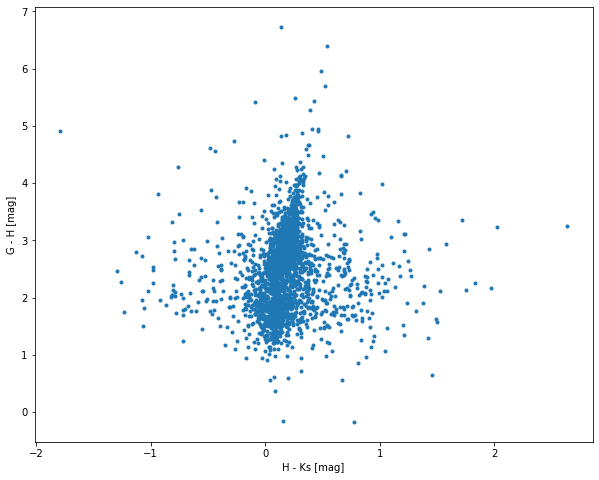

In [25]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(match_cat['Hmag'] - match_cat['Kmag'], 
        match_cat['Gmag'] - match_cat['Hmag'], linestyle='', marker='.')
ax.set_xlabel('H - Ks [mag]')
ax.set_ylabel('G - H [mag]')
plt.show()